In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Прогнозирование поведения клиента (ДЗ)

Привет!

В данном домашнем задании тебе предстоит построить кривые def rate, dlq ratio и clo rate (подробные пункты перечислены ниже). Для выполнения тебе понадобится выборка с данными, которую использовали на семинаре (**data_vintages.csv**), x_score с семинара (**data_scores.csv**) и PD, который ты получил по итогу выполнения предыдущего ДЗ (скор, предсказывающий вероятность выпадения в дефолт за первые 12 месяцев жизни кредита). Не бойся выходить за рамки методов, предлженных в лекции. Главное - не забывай **аргументировать** свой выбор и давать **комментарии** своим действиям. 

Удачи!

#### Как будет оцениваться ваша работа:
За это ДЗ ты можешь получить максимум **14 баллов** (10 за обязатеьную часть и 4 за часть со звездочкой). Все пункты весят по-разному, баллы указаны рядом с пунктами. Баллы могут сниматться в случае неполного выполнения задания или отсутствия аргументации.

Задание со зведочкой не обязательно к выполнению.

#### Задачи:

1) Построить кривые DEF rate и DLQ ratio, используя PD, полученный на предыдущем ДЗ. В качестве результаты приложите отдельный ноутбук с названием 'Surname_def_dlq.ipynb' (1 балл)

2) Построить кривые CLO rate 
    - Построить винтажи CLO ratio (1 балл)
    - Выбрать переменную для разбивки по бакетам (2 балла)
    - Провести анализ поколений (0.5 баллов)
    - Построить винтажи CLO rate (2 балла)
    - Провести анализ на особые точки (0.5 балла)
    - Построить среднее по винтажам для каждого бакета (1 балл)
    - Сгладить кривые (2 балла)
    
3) * Провести анализ на наличие макроэкономического воздействия (4 балла)

В качестве результата по пунктам 2 и 3 приложите текущий ноутбук с названием 'Surname_clo.ipynb'

In [ ]:
import importlib
import pickle
# import risk_instruments
import pandas as pd
import numpy as np
import os
import sys
import pandas as pd
import plotly.io as pio
import seaborn as sns
import plotly.graph_objects as go

from google.colab import drive
drive.mount('/content/drive')

# from risk_instruments.database import DBconnect
# from risk_instruments.universal_analysis import woe_stab, woe_line
# from risk_instruments.express_analysis import gain_chart
# from configures import user, password
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.pipeline import Pipeline
from IPython.core.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats.distributions import chi2
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier, plot_importance
from scipy.stats import bernoulli, norm
from plotly.subplots import make_subplots
import lightgbm as lgb
from scipy.optimize import minimize

# importlib.reload(risk_instruments.database)
pio.renderers.default='notebook'
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
display(HTML("<style>.container { width:100% !important; }</style>"))

Mounted at /content/drive


## Кривые CLO rate

#### Выгружаем данные с винтажами

In [ ]:
# В качестве данных для винтажей используй файл с семинара data_vintages.csv

# перекинул данные модели из прошлой дз(передал обученный бустинг, так как качество у него было лучше)
import joblib
bust_model = joblib.load('/content/sample_data/model.pkl')

path = '/content/sample_data/data_scores_and_features-0667850d-f03d-4d60-9ffc-93cb745050b4.csv'
df = pd.read_csv(path)

df.head()

user_id                   pd            x_score  max_util  avg_util  \
0     5269   0,0390977205391442  0,127199135674353  0.000000  0.000000   
1   157747  0,00298839119397661  0,624327037460113  0.000000  0.000000   
2   112119   0,0634189586034202  0,166025075663731  0.906661  0.777738   
3   131663   0,0538517590370807  0,097733043837605  1.003618  0.381491   
4   122778   0,0462823278081679  0,458679924133087  0.900334  0.347921   

   credits_2y  credits_4y  bad_history_credits_flg  other_util    avg_term  \
0         0.0         0.0                        1    0.210959   -7.111111   
1         0.0         0.0                        1    0.200141  190.714286   
2         0.0         0.0                        1    0.887264   19.000000   
3         1.0         1.0                        1    0.371895  138.500000   
4         0.0         0.0                        0    0.366521    8.200000   

   min_term  avg_limit_mortgage  min_limit_mfo  close_balance_amt  \
0     -57.0                -1.0           -1.0                0.0   
1       5.0           3545000.0           -1.0            39646.0   
2      16.0                -1.0           -1.0             9087.0   
3      12.0                -1.0           -1.0          1262802.0   
4       3.0                -1.0           -1.0            10801.0   

   soc_dem_score  max_delq_cnt  avg_active_time  last_credit_time_years  
0      -5.834056           0.0             -1.0                     0.0  
1      -7.996644           0.0            170.0                     0.0  
2      -4.420416           0.0             21.0                     1.0  
3      -6.395523           0.0             60.0                     2.0  
4      -6.920208           0.0             16.0                     2.0

#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [ ]:
# Тебе понадобятся два скора: 
# 1) x_score из файла data_scores.csv 
# 2) PD (вероятность дефолта за 12 месяцев), который вы получили в предыдущем ДЗ

features = list(df.columns)
features

['user_id',
 'pd',
 'x_score',
 'max_util',
 'avg_util',
 'credits_2y',
 'credits_4y',
 'bad_history_credits_flg',
 'other_util',
 'avg_term',
 'min_term',
 'avg_limit_mortgage',
 'min_limit_mfo',
 'close_balance_amt',
 'soc_dem_score',
 'max_delq_cnt',
 'avg_active_time',
 'last_credit_time_years']

In [ ]:
# Препроцессинг
features.remove('user_id')
features.remove('pd')
features.remove('x_score')

# корреляты 
features.remove('avg_util')
features.remove('credits_2y')
features.remove('min_term')

# слабые фияи по ROC-AUC

features.remove('avg_active_time')
features.remove('avg_term')
features.remove('bad_history_credits_flg')
features.remove('max_delq_cnt')

In [ ]:
new_pd = bust_model.predict_proba(df[features])[:, 1]
new_pd

array([0.0600106 , 0.03228317, 0.08920206, ..., 0.02096657, 0.01634519,
       0.04092633])

In [ ]:
# обновил значения столбца pd своими значениями, не меняя x_score
df['x_score'] = [x.replace(',', '.') for x in df['x_score']]
df['x_score'] = df['x_score'].astype(float)


df_scores = pd.DataFrame({'user_id': df['user_id'], 'pd': new_pd, 'x_score': df['x_score']})
df_scores

user_id        pd   x_score
0         5269  0.060011  0.127199
1       157747  0.032283  0.624327
2       112119  0.089202  0.166025
3       131663  0.087466  0.097733
4       122778  0.073016  0.458680
...        ...       ...       ...
59370   177839  0.067365  0.263185
59371   186550  0.039532  0.141886
59372   190090  0.020967  0.415375
59373    36916  0.016345  0.280195
59374   159897  0.040926  0.160525

[59375 rows x 3 columns]

In [ ]:
vintage1 = pd.read_csv('/content/sample_data/data_vintages1-b183c416-d3e2-482a-9dab-20f0191e7ed5.csv')
vintage2 = pd.read_csv('/content/sample_data/data_vintages2-545c8f7a-aa95-4479-9dfa-34a514871c53.csv')

data_vintages = pd.concat([vintage1, vintage2], ignore_index=True)
data_vintages.head()

user_id  statement_num gen_month_dt gen_quarter_dt  clo_flg  def_flg  \
0   127336             19   2019-07-01     2019-07-01      0.0      0.0   
1    35907             16   2019-04-01     2019-04-01      1.0      0.0   
2    45228             21   2019-05-01     2019-04-01      0.0      0.0   
3    39035             23   2019-07-01     2019-07-01      0.0      0.0   
4   130780             19   2019-08-01     2019-07-01      1.0      0.0   

   dlq_flg  act_flg  prev_clo_flg  prev_def_flg  prev_dlq_flg  prev_act_flg  
0      0.0      1.0           0.0           0.0           0.0           1.0  
1      0.0      0.0           1.0           0.0           0.0           0.0  
2      0.0      1.0           0.0           0.0           0.0           1.0  
3      0.0      1.0           0.0           0.0           0.0           1.0  
4      0.0      0.0           1.0           0.0           0.0           0.0

#### Бъем выборку на бакеты и джойним с данными с винтажами

In [ ]:
# Разбей данные на 3 бакета по каждой переменной

df_scores = df_scores.sort_values(['pd'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['pd_bucket'])['pd'].mean())

df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['x_bucket'])['x_score'].mean())

data_vintages = data_vintages.merge(df_scores[['user_id', 'pd_bucket', 'x_bucket', 'pd', 'x_score']], how='left', on='user_id').dropna()
data_vintages.head()

pd_bucket
0    0.030586
1    0.055988
2    0.098652
Name: pd, dtype: float64
x_bucket
0    0.133434
1    0.220700
2    0.379589
Name: x_score, dtype: float64


user_id  statement_num gen_month_dt gen_quarter_dt  clo_flg  def_flg  \
3     39035             23   2019-07-01     2019-07-01      0.0      0.0   
4    130780             19   2019-08-01     2019-07-01      1.0      0.0   
10    26236             16   2019-04-01     2019-04-01      1.0      0.0   
14   172575             23   2019-11-01     2019-10-01      1.0      0.0   
15   158523             24   2019-09-01     2019-07-01      0.0      0.0   

    dlq_flg  act_flg  prev_clo_flg  prev_def_flg  prev_dlq_flg  prev_act_flg  \
3       0.0      1.0           0.0           0.0           0.0           1.0   
4       0.0      0.0           1.0           0.0           0.0           0.0   
10      0.0      0.0           1.0           0.0           0.0           0.0   
14      0.0      0.0           1.0           0.0           0.0           0.0   
15      0.0      1.0           0.0           0.0           0.0           1.0   

    pd_bucket  x_bucket        pd   x_score  
3         0.0       1.0  0.033426  0.210896  
4         0.0       1.0  0.039842  0.269492  
10        2.0       1.0  0.077580  0.225590  
14        2.0       2.0  0.123527  0.561421  
15        1.0       1.0  0.061765  0.210751

In [ ]:
data_vintages['statement_num'] = data_vintages['statement_num'].astype(int)

### Построй винтажи кривой Clo ratio (1 балл)


Clo ratio - доля закрытых счетов:
### $$ CLO ratio_n = \frac{\#CLO_n}{\#cnt_n}$$


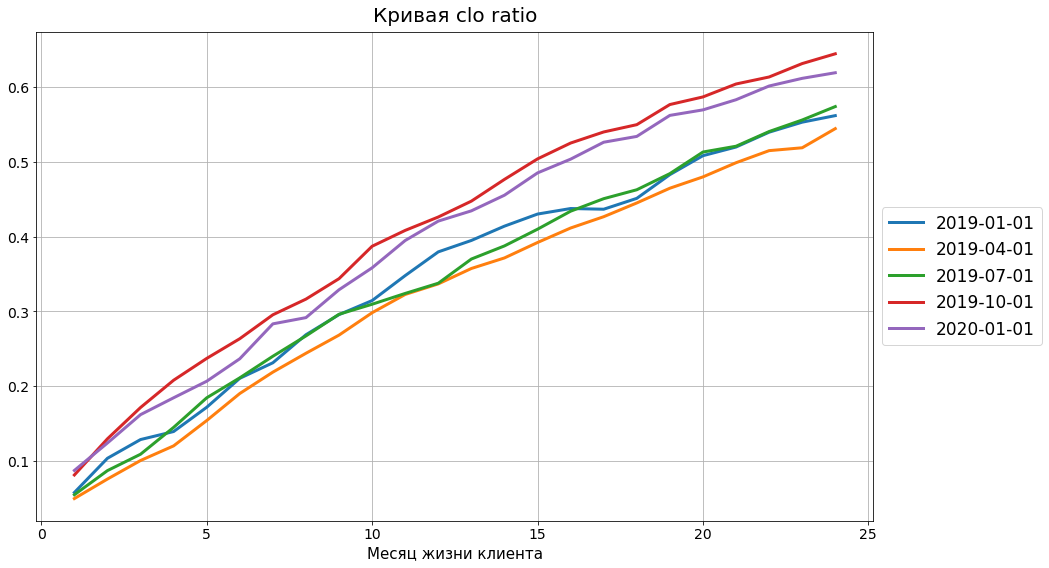

In [ ]:
def plot_clo_ratio_by_generation(data_vintages):
    return (data_vintages.groupby(["gen_quarter_dt", "statement_num"])
            .agg({"clo_flg":np.mean})
            .rename(columns = {"clo_flg": 'clo_ratio'})
            .unstack('gen_quarter_dt')
            ['clo_ratio']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))               

# Строим график при помощи pyplot
plot_clo_ratio_by_generation(data_vintages)

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая clo ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Выбери переменную, которая делит кривые наилучшим образом (2 балла)

 Из двух скоров (x_score и ваш PD) выбери тот, который разделяет кривые наилучшим образом

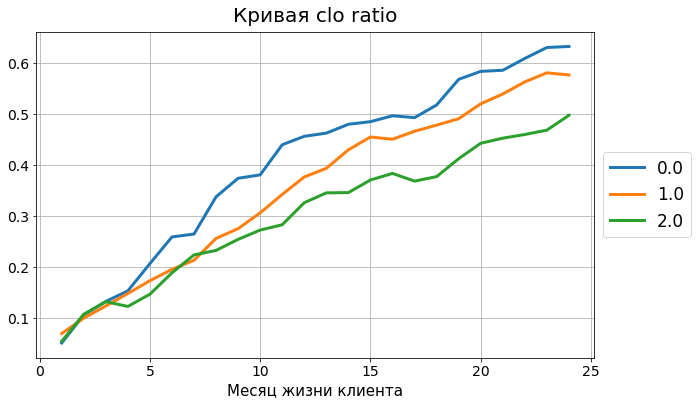

In [ ]:
def plot_default_ratio_by_bucket(data_vintages, bucket):
    return (data_vintages.query(''' gen_quarter_dt == '2019-01-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"clo_flg":np.mean})
            .rename(columns = {"clo_flg": 'clo_ratio'})
            .unstack(bucket)
            ['clo_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_default_ratio_by_bucket(data_vintages, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая clo ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

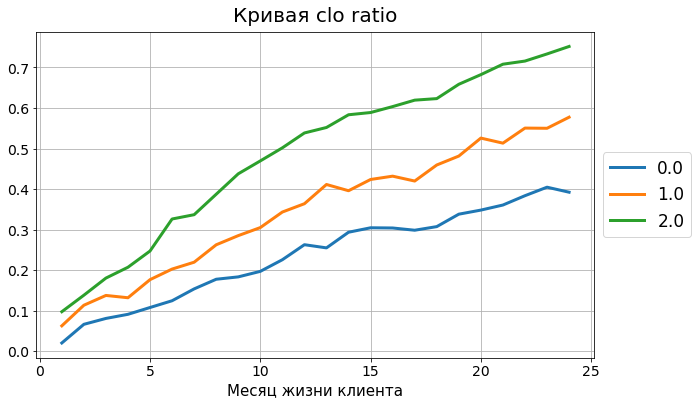

In [ ]:
plot_default_ratio_by_bucket(data_vintages, 'x_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая clo ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: здесь укажи выбранную тобой переменную и обоснуй свой выбор
Видно, что x_score лучше разделяет прямые. Видно из расстояний между прямыми

### Анализ странных поколений (0.5 баллов)

Отрисуй распределение данных во времени в разбивке по выбранной перменной

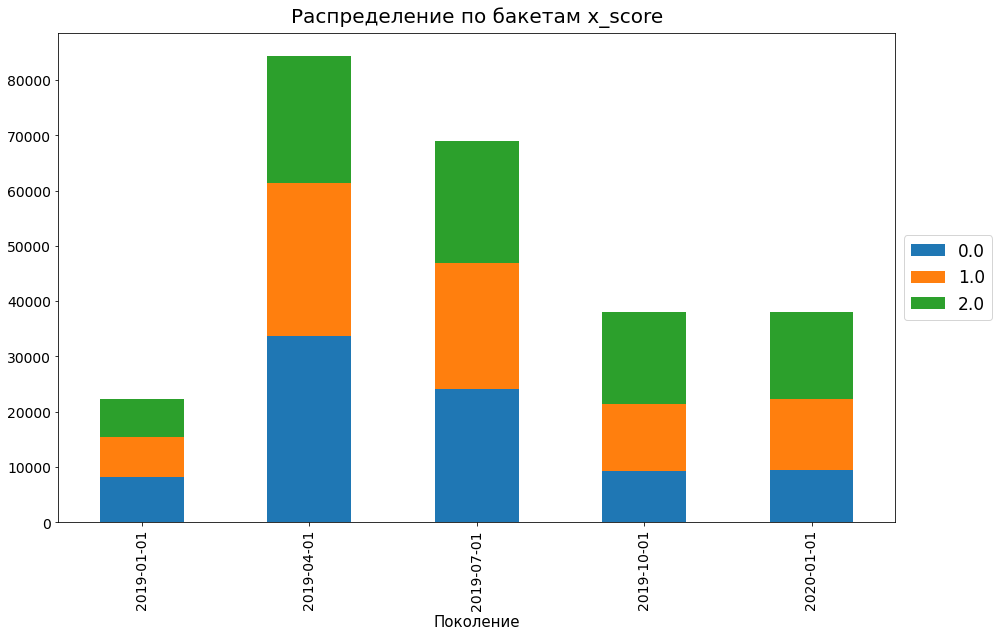

In [ ]:
def plot_distribution(data_vintages, bucket):
    return pd.pivot_table(data_vintages, index=[bucket], columns='gen_quarter_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(data_vintages, 'x_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам x_score", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: сделай выводы по полученным графикам. Нужно ли исключать какие-то бакеты/поколения? Если да, то реализуй их исключение из выборки

Единственный бакет, который может смущать это первый. Но мне кажется, что в нем достаточно данных, чтобы его оставить. Не буду его убирать. 

### Кривые СLO Rate в разбивке по бакетам 

$CLO_n$ - количество счетов, закрывшихся в месяц $n$

$ACT_{n-1}$ - количество активных счетов (в просрочке 0-3) в месяц $n-1$

## $$ CLO Rate_n = \frac{\#CLO_n}{\#Act_{n-1}} $$

Реализуй функцию, которая отрисовывает винтажи CLO rate в разбивке по бакетам

In [ ]:
from ipywidgets import interactive
%matplotlib inline
# Выгружаем таблицу c винтажами

clo_rate_data = data_vintages.eval('clo_new_flg = clo_flg * prev_act_flg', inplace=False)\
    .groupby(["gen_quarter_dt", 'x_bucket', "statement_num"])\
    .agg({"clo_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"clo_new_flg":'clo_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('clo_rate = clo_cnt / prev_act_cnt', inplace=False)


# Делаем список бакетов

buckets = data_vintages['x_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_clo_rate_by_generation(x_bucket):
    
    cur_clo = clo_rate_data.query('x_bucket == ' + str(x_bucket))
    (cur_clo.unstack('gen_quarter_dt')
            ['clo_rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая CLO rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

    
# Отображаем его при помощи ipywidget, чтобы получить интерактивность

vintages_graph = interactive(plot_clo_rate_by_generation, x_bucket = buckets)
vintages_graph

interactive(children=(Dropdown(description='x_bucket', options=(0.0, 1.0, 2.0), value=0.0), Output()), _dom_cl…

#### Выводы: сделай выводы по полученным графикам

### Особые точки (0.5 баллов) 
#### Есть ли в винтажах особые точки? Укажи их. Какова их природа? Нужно ли их исключать?



Ответ: Да, есть например синяя прямая в нулевой бакете. У нее есть одна странная точка, между 16 и 21 месяцем все кривые так или иначе идут вверх, кроме синей. Также наблюдаются какие-то непонятные экстремумы, поэтому есть мысль ее удалить. В остальным бакетам все более менее нормально, их трогать не буду. Еще в том же бакете немного смущает фиолетовая линия, но они ближе к среднему(видно далее) и в целом отличается от остальных небольшой остротой пиков. Природа синей линии может заключаться в том, что просто в этот бакет попали такие данные, которые немного выбивают эту линию от остальных.

### Среднее по бакетам (1 балл)
Выбери один из способой нахождение средней кривой (возможные способы указаны в лекции). Обоснуй свой выбор.

Реализуй функцию построения среднего.

Построим самое обычное среднее. 

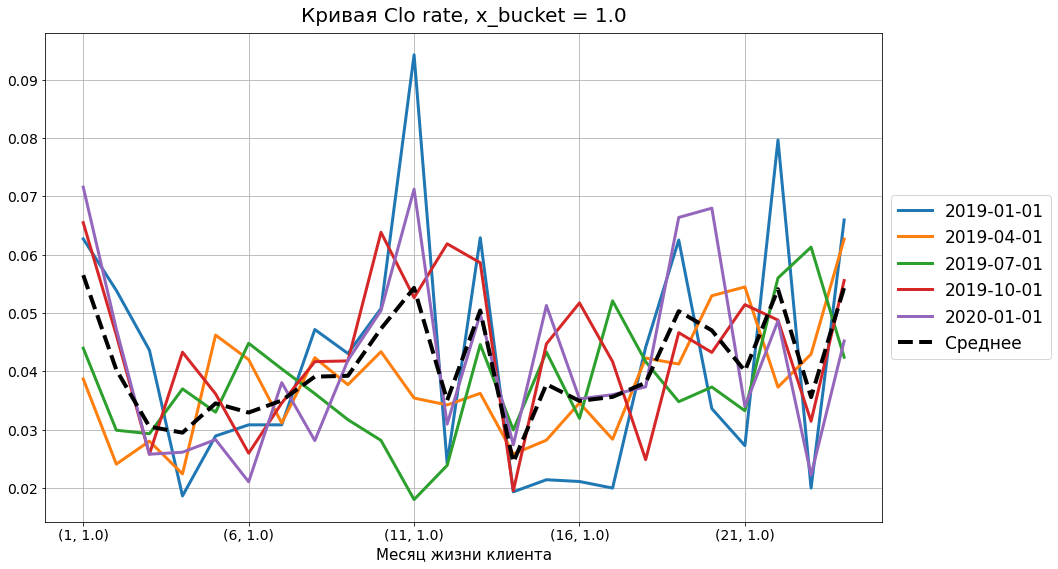

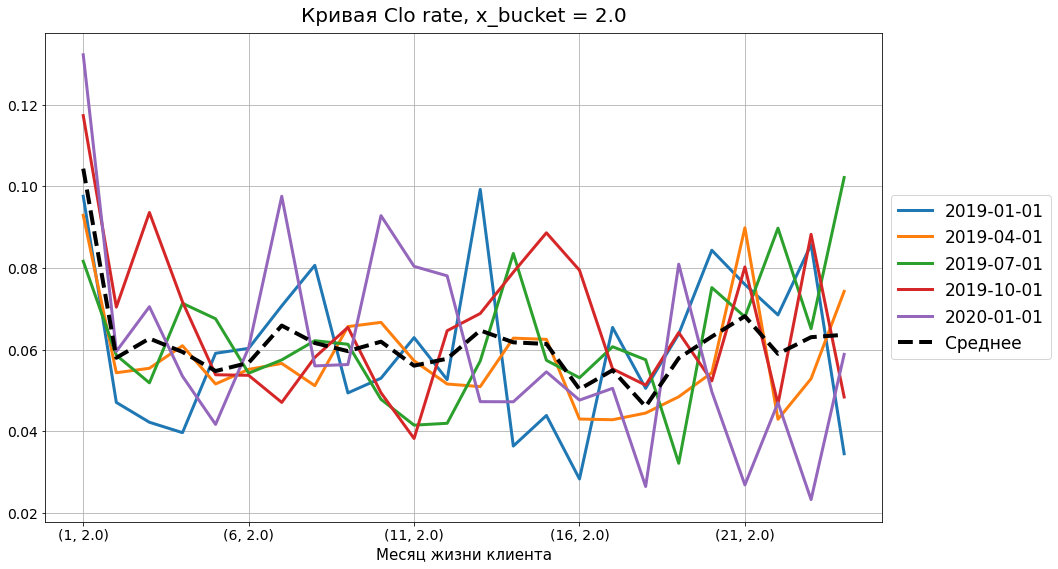

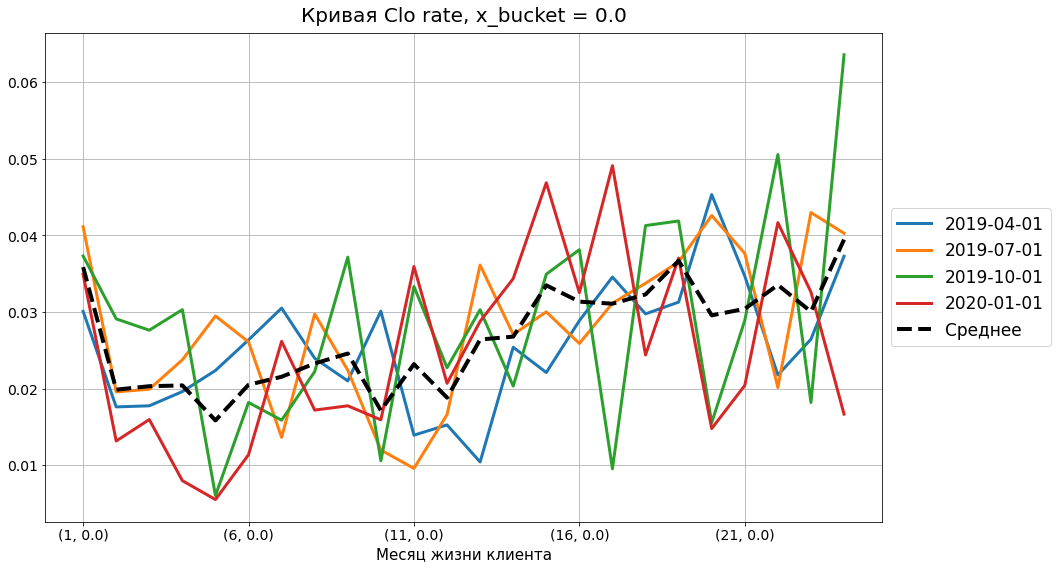

In [ ]:
exception_query = ''' ~((gen_quarter_dt == '2019-01-01') & (x_bucket == 0)) '''
clo_rate_data.query(exception_query, inplace = True)

clo_rate_mean = clo_rate_data.groupby(['statement_num', 'x_bucket'])\
    .agg({'clo_rate':np.mean})\
    .rename(columns = {'clo_rate':'Среднее'})

buckets = data_vintages['x_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_default_rate_mean(x_bucket):
    vintages_graph = clo_rate_data.query('x_bucket == ' + str(x_bucket))\
            .unstack('gen_quarter_dt')\
            ['clo_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (clo_rate_mean.query('x_bucket == ' + str(x_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Clo rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_default_rate_mean(i)

Среднее гармоническое 

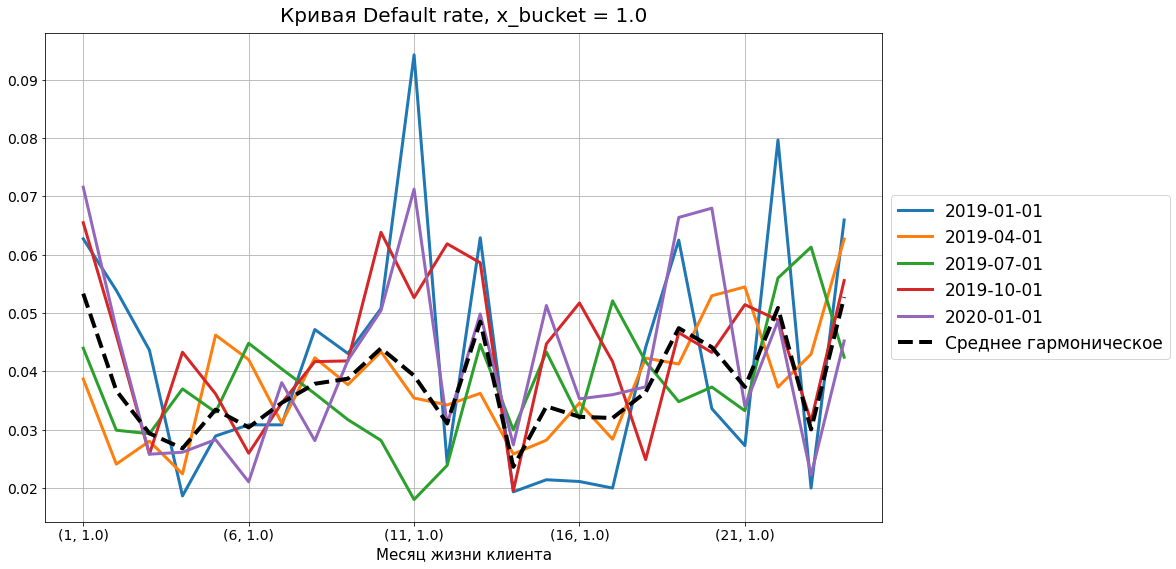

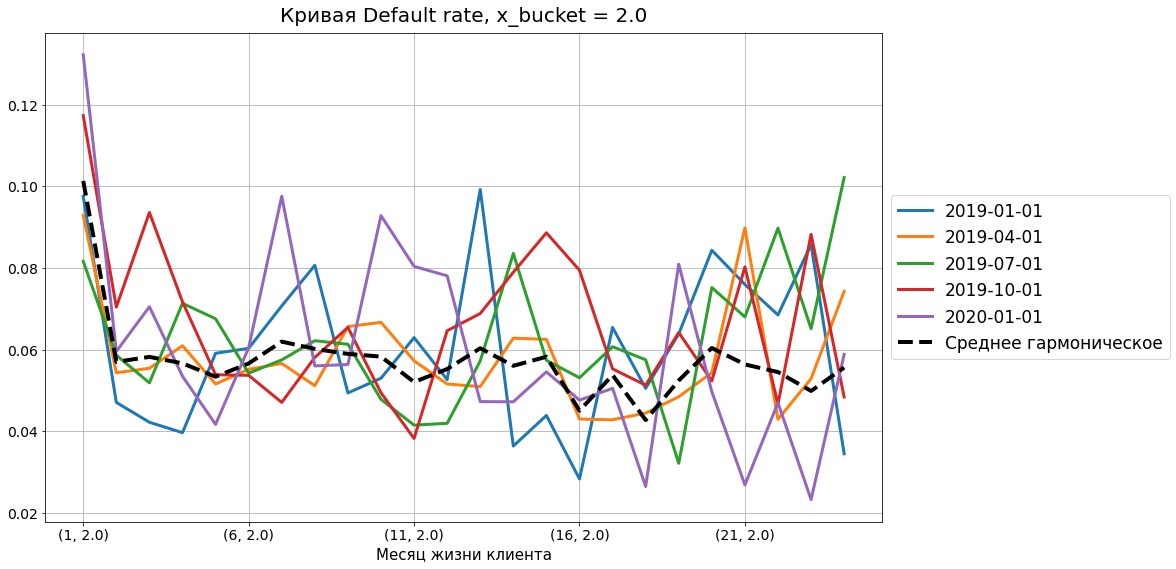

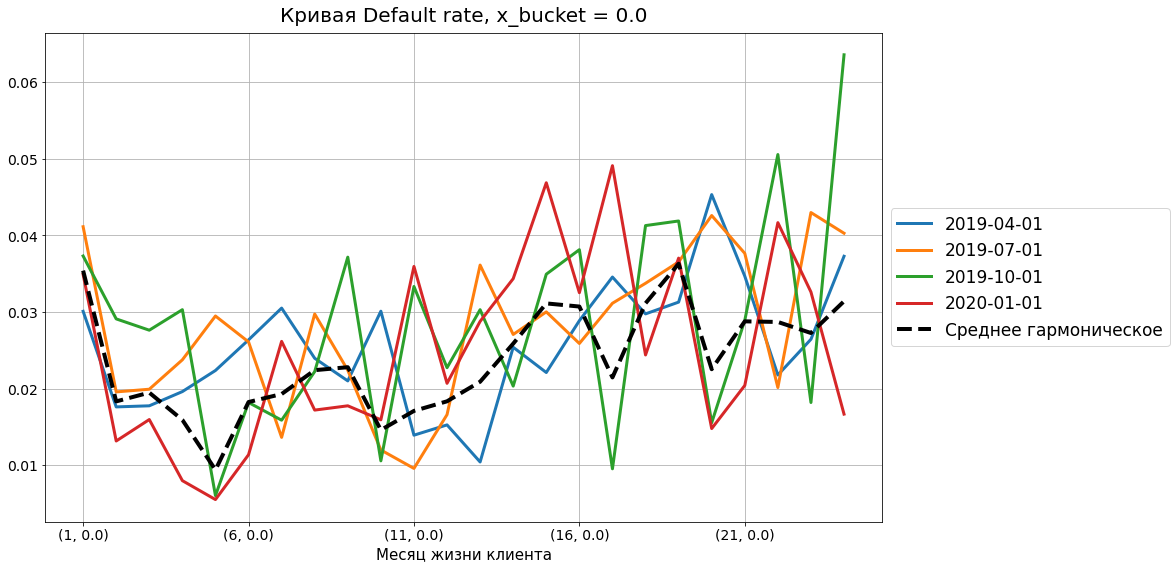

In [ ]:
import statistics

clo_rate_gar_mean = clo_rate_data.groupby(['statement_num', 'x_bucket'])\
    .agg({'clo_rate':statistics.harmonic_mean})\
    .rename(columns = {'clo_rate':'Среднее гармоническое'})

buckets = data_vintages['x_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_default_rate_mean(x_bucket):
    vintages_graph = clo_rate_data.query('x_bucket == ' + str(x_bucket))\
            .unstack('gen_quarter_dt')\
            ['clo_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (clo_rate_gar_mean.query('x_bucket == ' + str(x_bucket))
            ['Среднее гармоническое']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Default rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_default_rate_mean(i)

Среднее геометрическое 

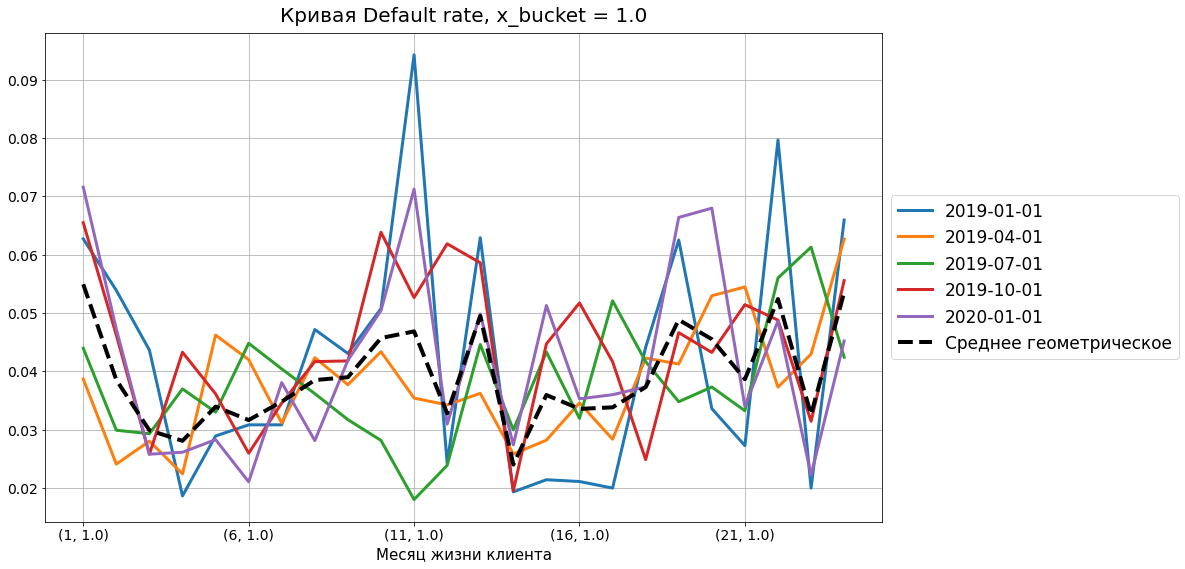

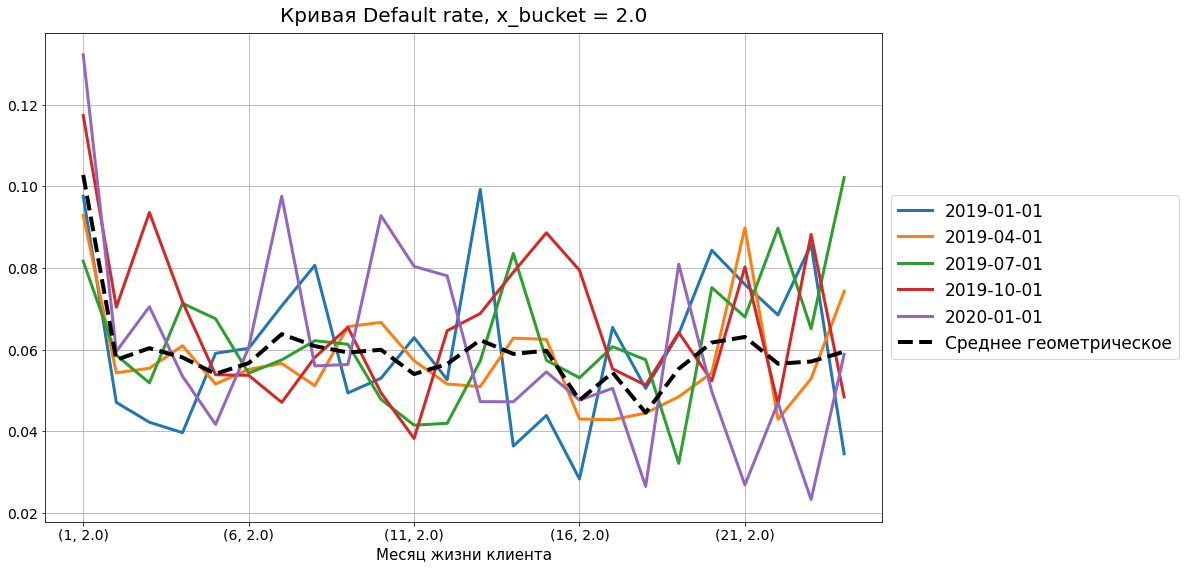

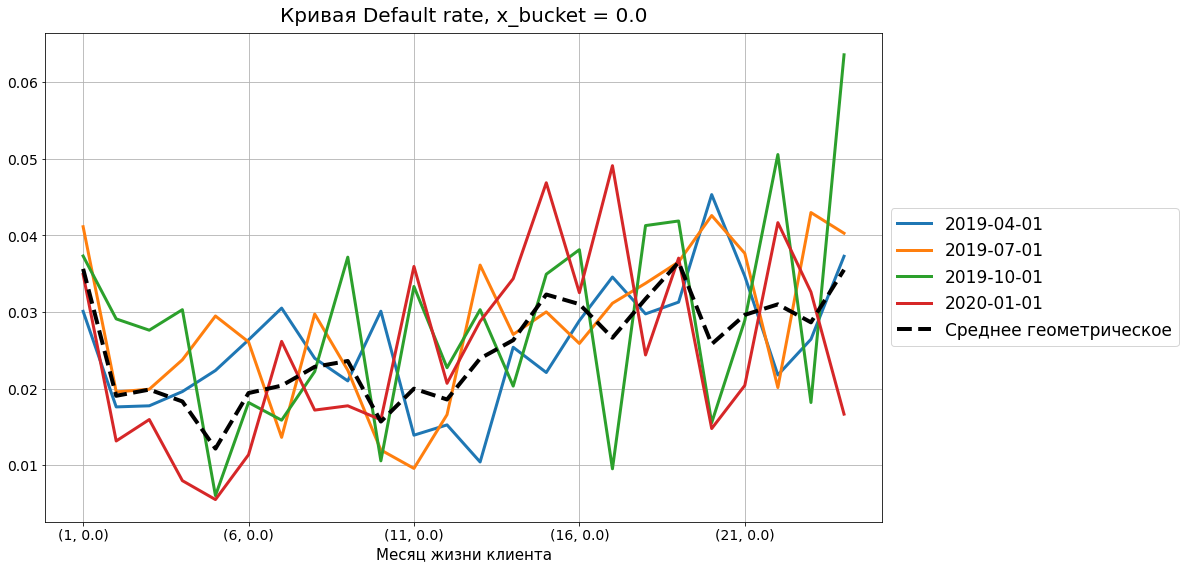

In [ ]:
import scipy.stats

clo_rate_geom_mean = clo_rate_data.groupby(['statement_num', 'x_bucket'])\
    .agg({'clo_rate':scipy.stats.gmean})\
    .rename(columns = {'clo_rate':'Среднее геометрическое'})

buckets = data_vintages['x_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_default_rate_mean(x_bucket):
    vintages_graph = clo_rate_data.query('x_bucket == ' + str(x_bucket))\
            .unstack('gen_quarter_dt')\
            ['clo_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (clo_rate_geom_mean.query('x_bucket == ' + str(x_bucket))
            ['Среднее геометрическое']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Default rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_default_rate_mean(i)

Кажется, что самое обычное среднее выглядит немного плавнее и резкие скачки наблюдаются реже. Поэтому не остановлюсь на обычном варианте среднего. 

### Сглаживание средних кривых (2 балла)

Рассмотри несколько функций для сглаживания кривой (можешь взять готовые из семинара, либо реализовать свои).

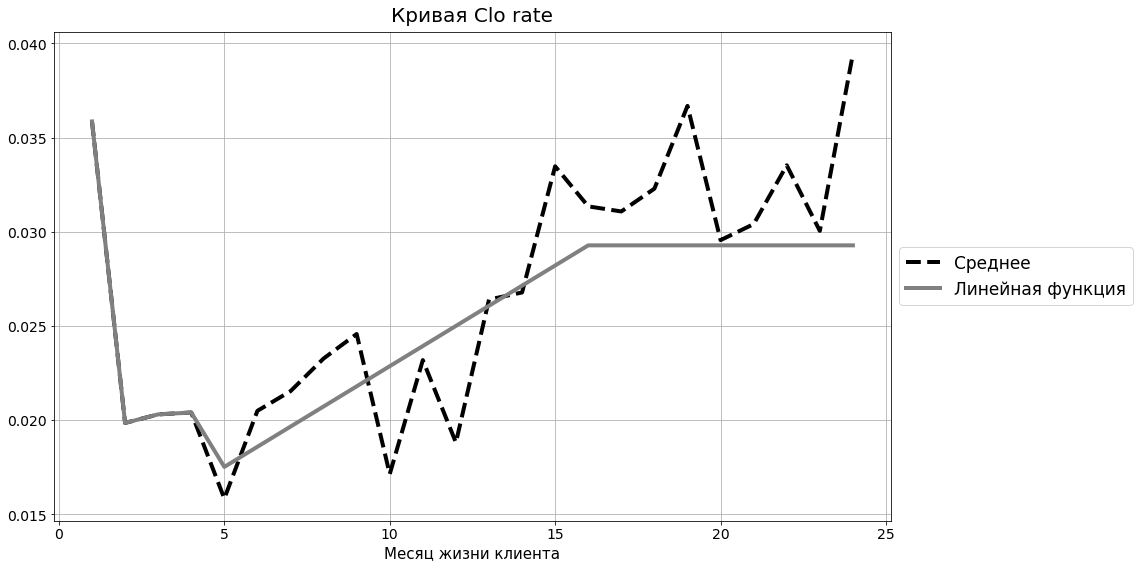

In [ ]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

# Делаем аппроксимацию

df_linear = clo_rate_mean.query('x_bucket == 0').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 5, 15)


# Строим получившийся график

plt.figure(figsize=(15, 9))
df_linear['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_linear['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Полином 2 степени 

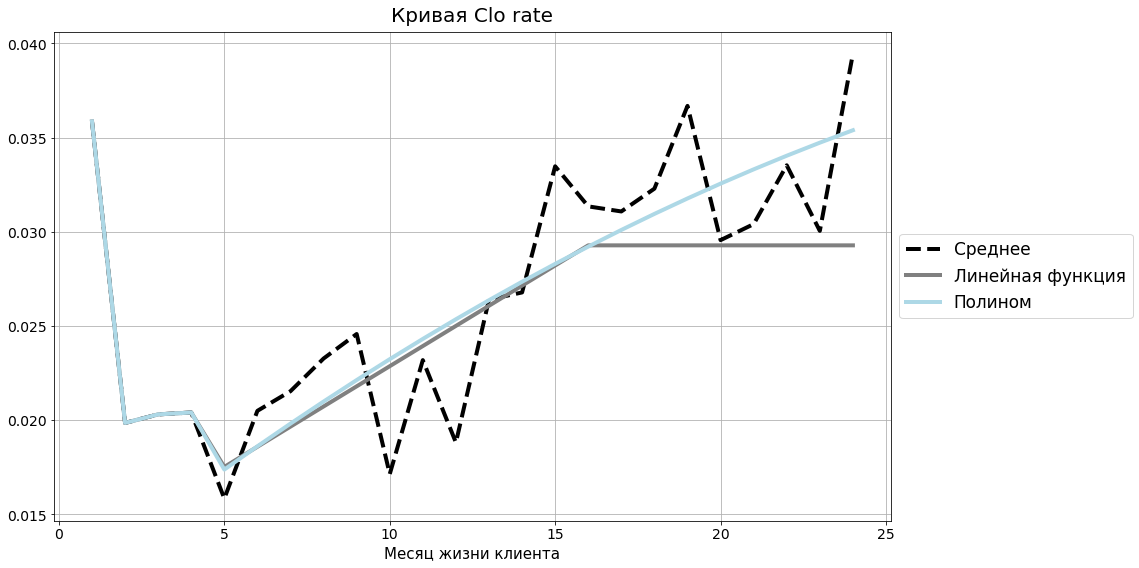

In [ ]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res


# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 5,24,2)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Полином 3 степени 

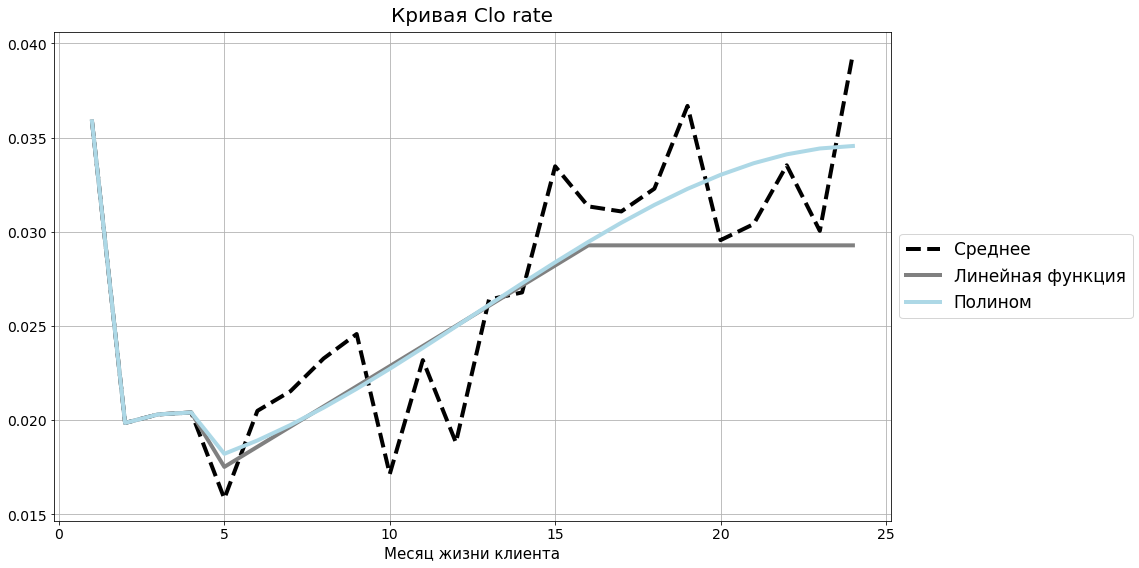

In [ ]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res


# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 5,24,3)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Полином 4 степени 

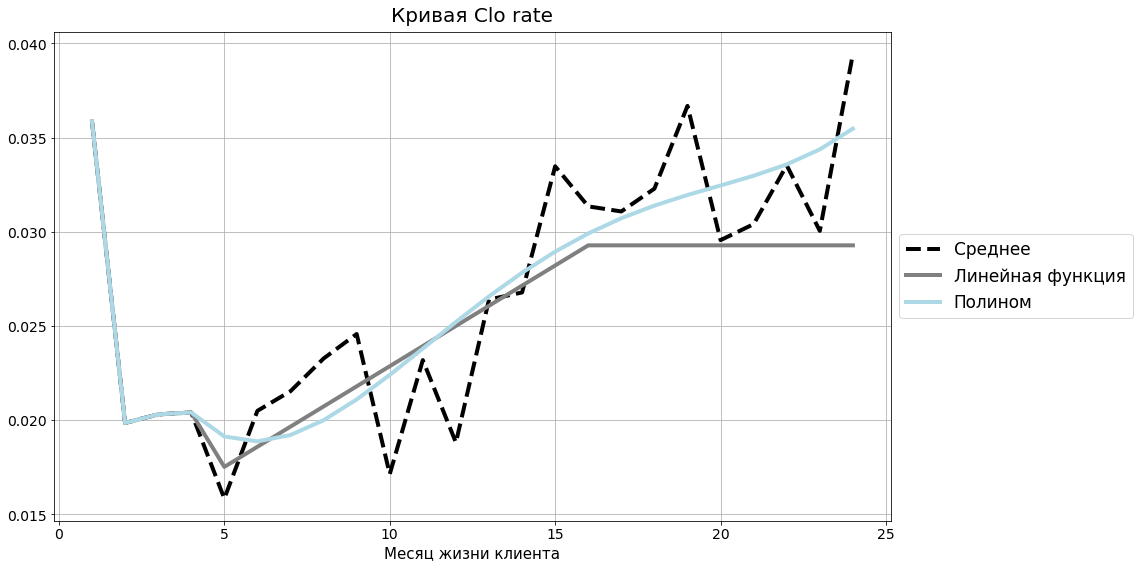

In [ ]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res


# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 5,24,4)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Экспоненциальное

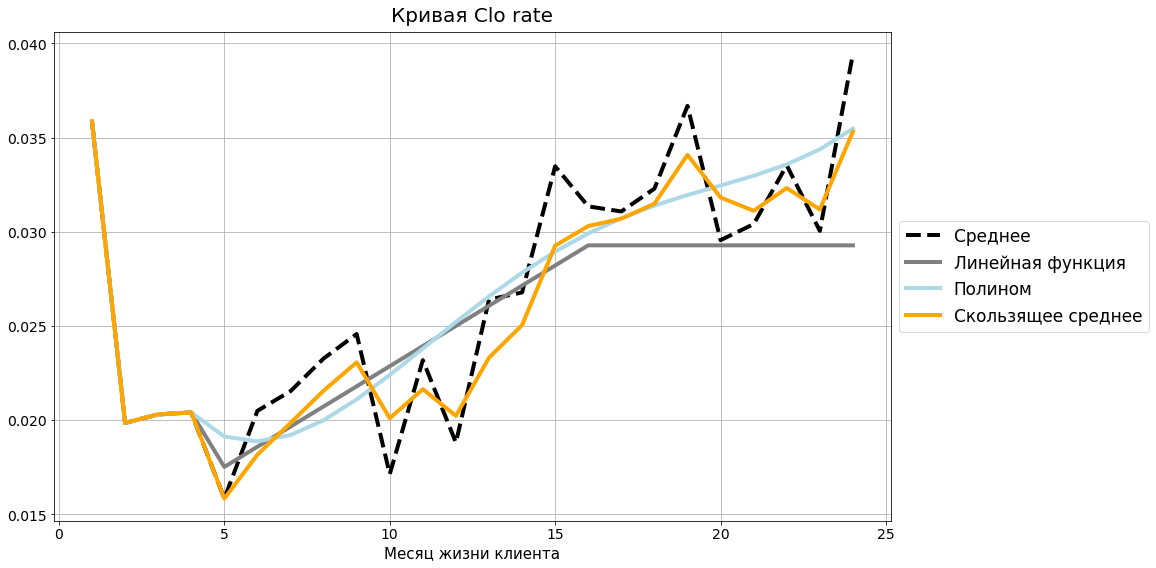

In [ ]:
def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])): 
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

# Строим экспоненциальное скользящее среднее с alpha = 0.25
df_smooth = exponential_smoothing(df_polynom, 5,24, 0.5)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Полином 4 степени приближает среднее лучше всего.Видно, что он уловил движения хвоста справа и в целом довольно неплохо реегирует на изменения среднего. Оставлю его .

#### Вывод: укажи выбранную функцию и обоснуй свой выбор. Были ли точки, к которым не применил сглаживание? Почему?

### Отрисуй сглаженные кривые по всем трем бакетам PD

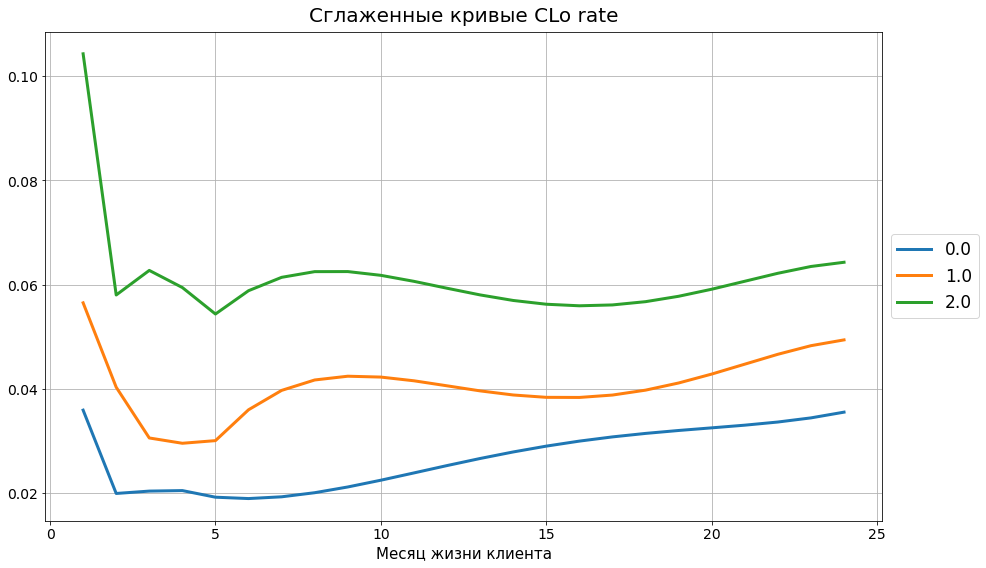

In [ ]:
buckets = data_vintages['x_bucket'].drop_duplicates().sort_values()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = clo_rate_mean.query('x_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 5,24,4)['Полином']
    
# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые CLo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

## (Задача со звездочкой) 
## Макроэкономические воздействие (4 балла)

#### Есть ли в винтажах CLO rate макроэкономическое воздействие? Если да, то предположи какое событие его вызвало и почему?
#### В случае наличия внешнего влияния 
#### 1) Разложи кривые на внешнее воздействие и созревание кривых
#### 2) Отрисуй график внешнего воздествия
#### 3) Отрисуй вычищенные винтажи Clo rate в разбивке по бакетам
#### 4) Посчитай среднее для этих бакетов и реализуй сглаживание

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import r2_score

def curve_build(data, 
                feature, 
                generation = 'generation_quart',
                statement_num = 'statement_num', 
                group_label = '1'):
    
    """Вспомогательная функция для построения разложения в рамках одного бакета
    
    Аргументы
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    where : str
        условие, которым мы ограничиваем выборку
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    Результат
    dictionary : dict
    """
    
    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов 
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])
    
    for i in range(tab_size):
         dates[i] = df_query.loc[i,generation].year * 12 + df_query.loc[i,generation].month -\
            generation_min.year * 12 - generation_min.month + df_query.loc[i,statement_num] - 1 

    # Определяем функционал, который будем минимизировать

    def r_square(x):
        temp = 0 
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt])**2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями

    x0 = np.array([0 for i in range(2*gen_cnt)])                                # Внешние воздействия

    # Численная минимизация

    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell', options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months = i) for i in range(gen_cnt)], 
                             group_label: res0.x[:gen_cnt]})

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице. 
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months = 6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean
    
    # И умножаем на полученный коэффициент кривые созревания
    
    maturation_array = np.transpose([res0.x[gen_cnt:2* gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array, \
                                           'statement_num': np.arange(1,maturation_array.size + 1)})

    df_fitted = df_query.merge(right=external_data, on = 'month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res

def decomposition(df, 
                  generation = 'generation_month', 
                  group = 'bucket', 
                  statement_num = 'statement_num', 
                  feature = 'feature', 
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени
    
    Аргументы
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    Результат
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов
 
    if optimization_query == '':
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)
    
    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x-1))
    df_query['month_dt'] = df_query[generation] + timedelta
    
      # Формируем список бакетов
    
    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())
    
    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))
        
        # Строим разложение для одного бакета
        res = curve_build(df_temp, 
                          feature = feature, 
                          generation = generation, 
                          statement_num = statement_num, 
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp]) 
        i+=1
        
    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }    
    return res_multiple

In [ ]:
# Подготавливаем данные
data_vintages['gen_month_dt'] = pd.to_datetime(data_vintages['gen_month_dt'])

clo_data_ratio = data_vintages.eval('clo_new_flg = clo_flg * prev_act_flg', inplace=False)\
        .groupby(["x_bucket","gen_month_dt", "statement_num"], as_index=False)\
        .agg({'clo_new_flg' : np.sum, "prev_act_flg":np.sum,  "user_id":np.count_nonzero})\
        .rename(columns = ({"clo_new_flg":'clo_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
        .eval('clo_rate = clo_cnt / prev_act_cnt', inplace=False) 
print(clo_data_ratio)
# Счетчик итераций
Nfeval = 0

# Проводим разложение кривых 
res = decomposition(clo_data_ratio, 
                       generation = 'gen_month_dt', 
                       group = 'x_bucket', 
                       statement_num = 'statement_num', 
                       feature = 'clo_rate')

      x_bucket gen_month_dt  statement_num  clo_cnt  prev_act_cnt  cnt  \
0          0.0   2019-02-01              1      0.0          24.0   24   
1          0.0   2019-02-01              2      1.0          21.0   21   
2          0.0   2019-02-01              3      0.0          23.0   24   
3          0.0   2019-02-01              4      0.0          17.0   18   
4          0.0   2019-02-01              5      0.0          19.0   21   
...        ...          ...            ...      ...           ...  ...   
1003       2.0   2020-03-01             20      0.0          46.0  222   
1004       2.0   2020-03-01             21      1.0          48.0  214   
1005       2.0   2020-03-01             22      2.0          49.0  227   
1006       2.0   2020-03-01             23      2.0          39.0  214   
1007       2.0   2020-03-01             24      1.0          38.0  221   

      clo_rate  
0     0.000000  
1     0.047619  
2     0.000000  
3     0.000000  
4     0.000000  
...      

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1190: PerformanceWarning:

Adding/subtracting object-dtype array to DatetimeArray not vectorized



0  0.194048
1  0.181700
2  0.181520
3  0.181502
4  0.181494
5  0.181475
6  0.181470
7  0.181359
8  0.181310
9  0.181060
10  0.180963
11  0.180521
12  0.180345
13  0.179567
14  0.179221
15  0.177479
16  0.176390
17  0.168917
18  0.159673
19  0.126929
20  0.116758
21  0.111027
22  0.108661
23  0.107627
24  0.107090
25  0.106313
26  0.106246
27  0.106208
28  0.106185
29  0.106112
30  0.106104
31  0.106099
32  0.106096
33  0.106095
34  0.106094
35  0.106092
36  0.106092
37  0.106087
38  0.106085
39  0.106071
40  0.106065
41  0.105795
42  0.105713
43  0.103193
44  0.102227
45  0.094523
46  0.093887
47  0.093378
48  0.091621
49  0.091574
50  0.091506
51  0.091492
52  0.091440
53  0.091439
54  0.091439
55  0.091439
56  0.091437
57  0.091437
x_bucket = 1.0
Initial 0.738565
58  0.322095
59  0.291629
60  0.291473
61  0.291439
62  0.291272
63  0.291174
64  0.290062
65  0.289699
66  0.287694
67  0.286957
68  0.282688
69  0.280896
70  0.268872
71  0.262331
72  0.230035
73  0.217817
74  0.175699
75 

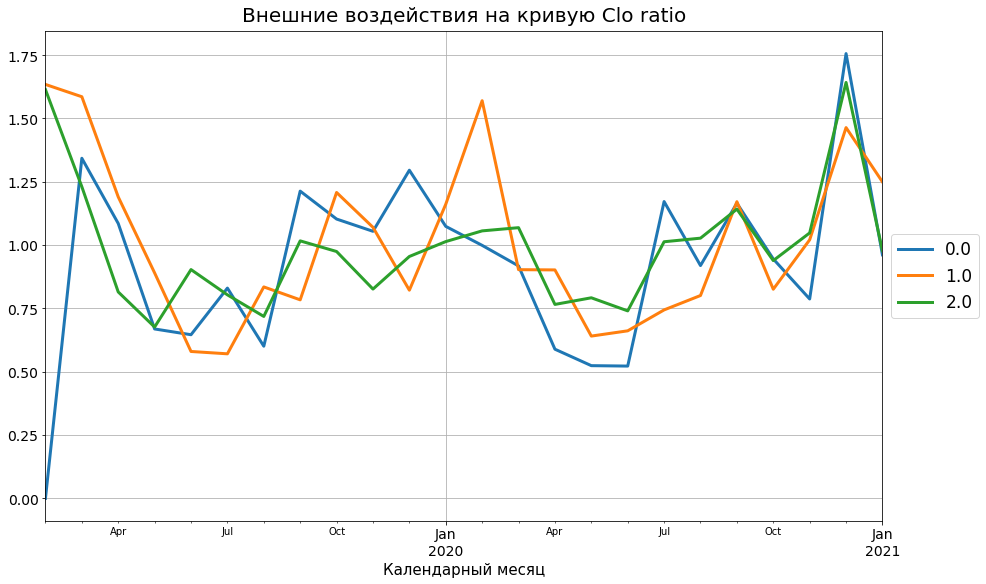

In [ ]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую Clo ratio", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

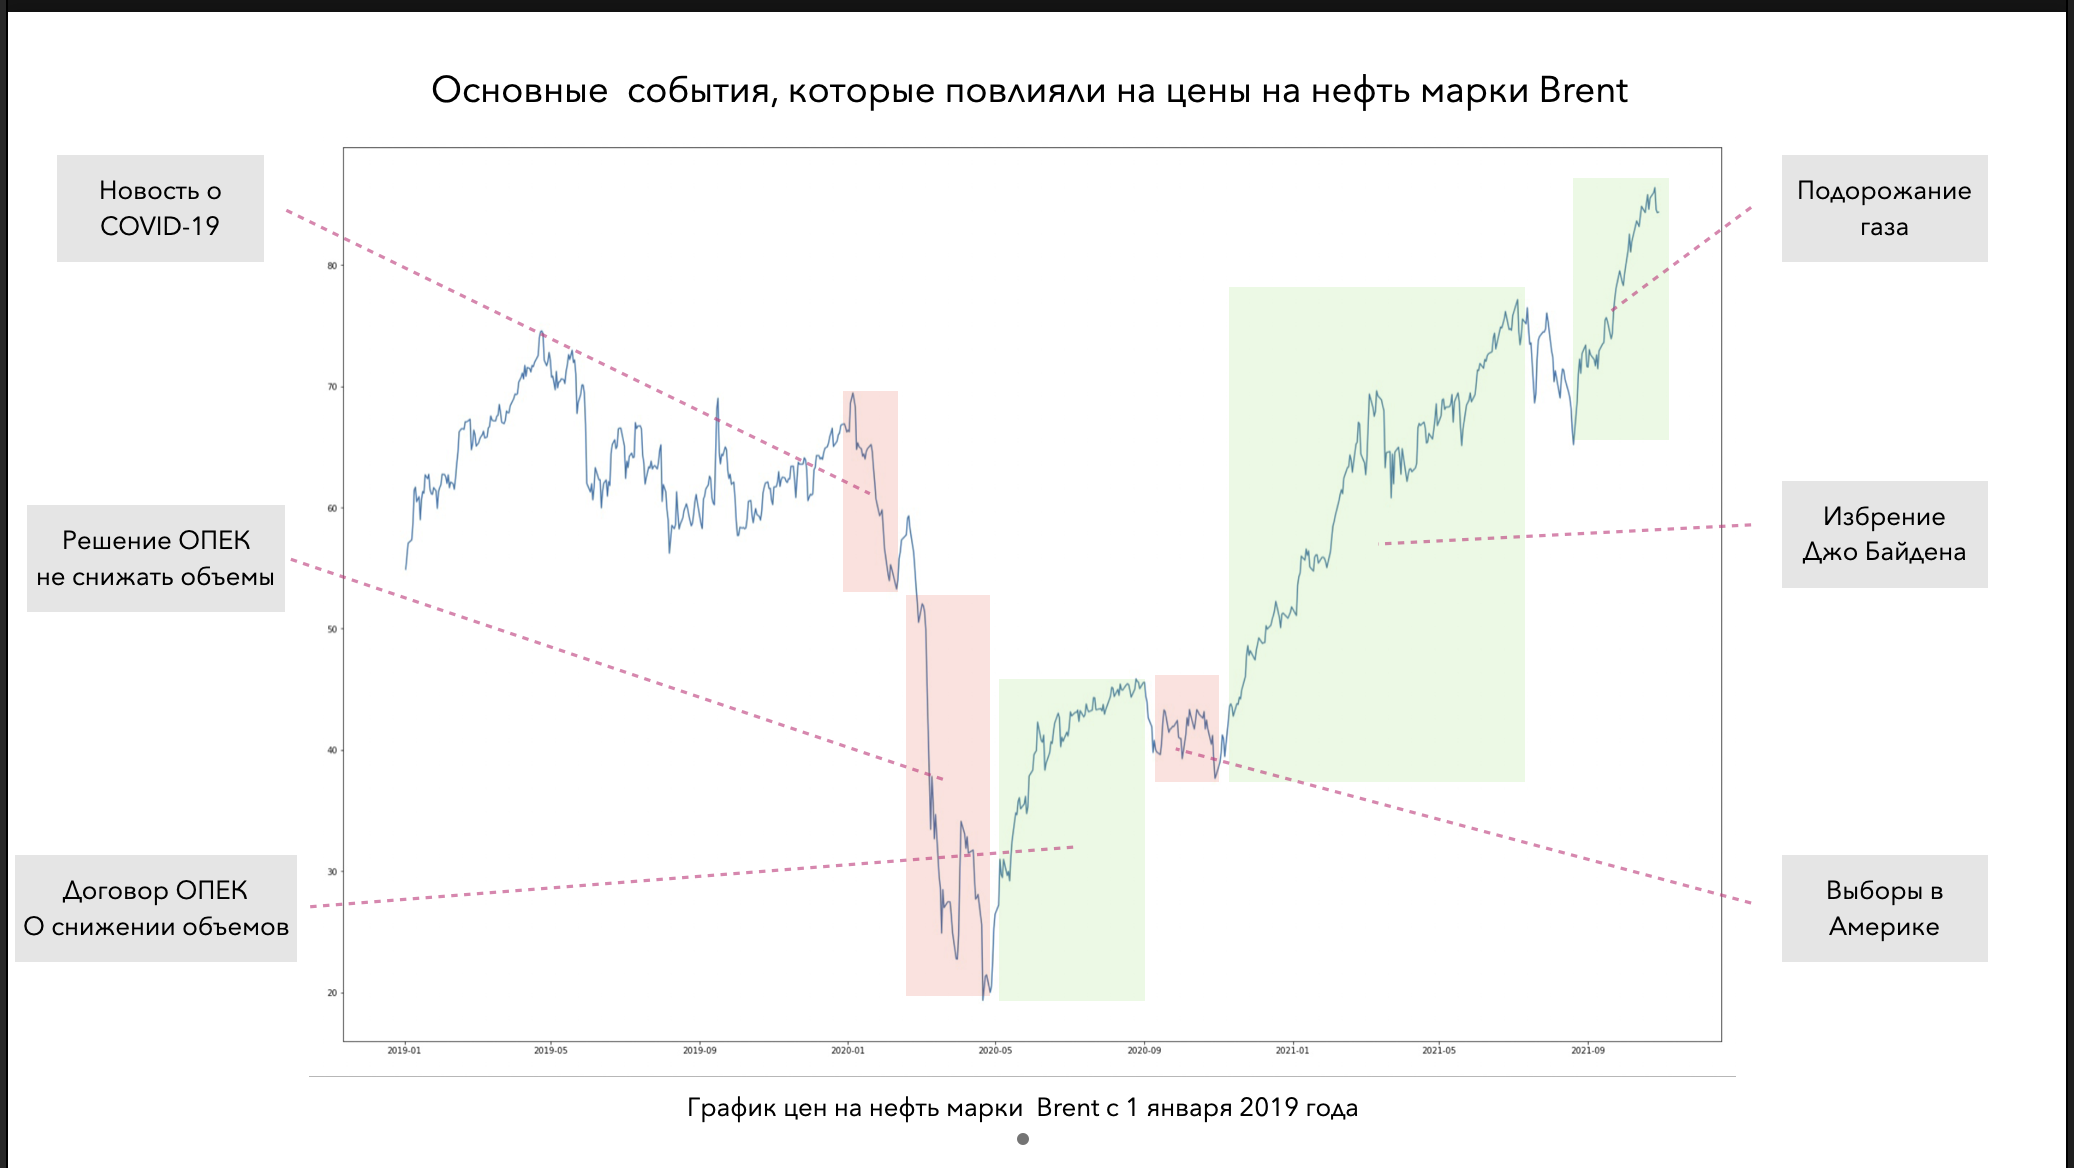

In [ ]:
from IPython.display import Image

Image('/content/sample_data/Снимок экрана 2022-04-23 в 02.03.17.png')

Видим две интересные точки
1.   Это апрель-май 20 года. Здесь начался коронавирус во всем мире. Я прикрепил график самой торгуемой нефти марки Brent(делал сам). Соответственно мы на нем видим в этот момент сильное падение цен на нефть в связи с решением ОПЕК не снидать объемы. Так как цены на нефть для многих стран являются довольно важный поинтов(в том числе и для очень крупного экспортера России), то понятно почему мы видим такой резкий сдвиг вниз. 
2.  Второе это возвращение к доапрельским уровням, а затем и продолжительный рост. Я думаю, что именно это и явялется объяснением такого поведения на графике. Можно соединить параллельными линиями точки на верхнем графике и на графике нефти, и будет видно, что тенденция в соединенных точках одинаковая. Можно сказать, что такие события меняют экономическое поведение людей. 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



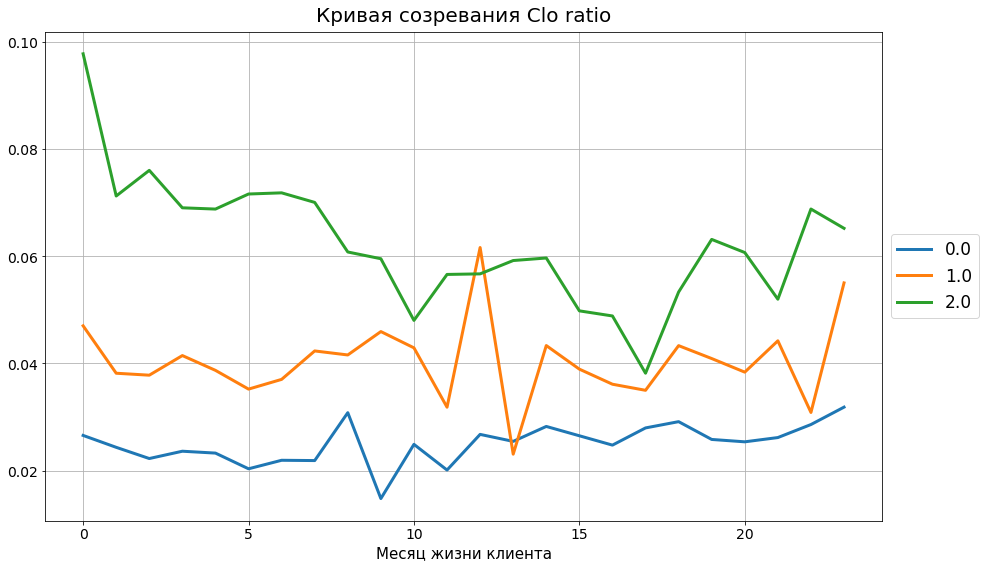

In [ ]:
res['maturation_data'].drop('statement_num', 1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая созревания Clo ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)



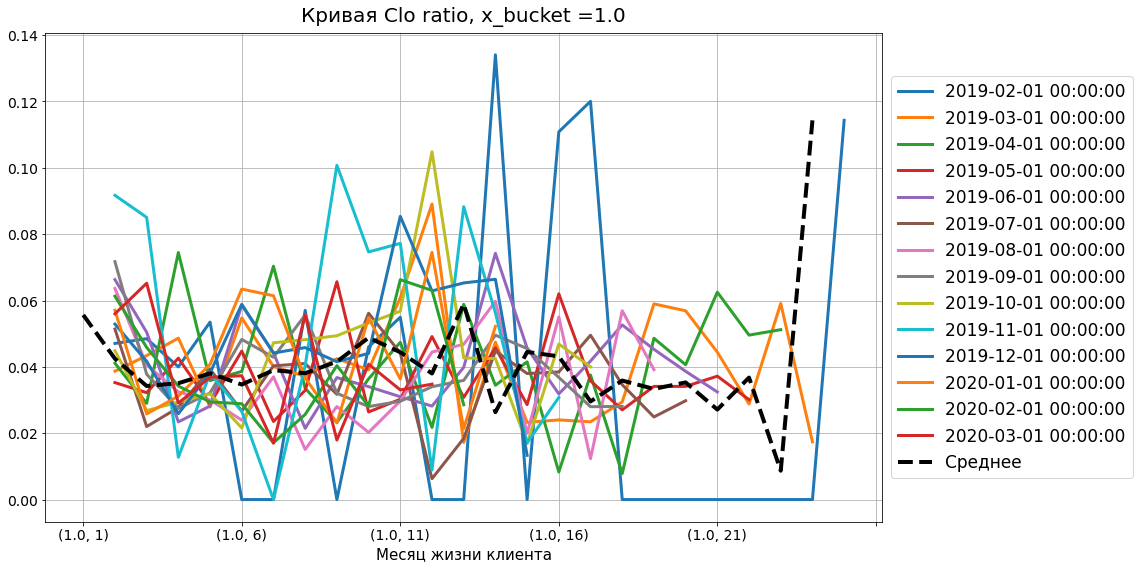

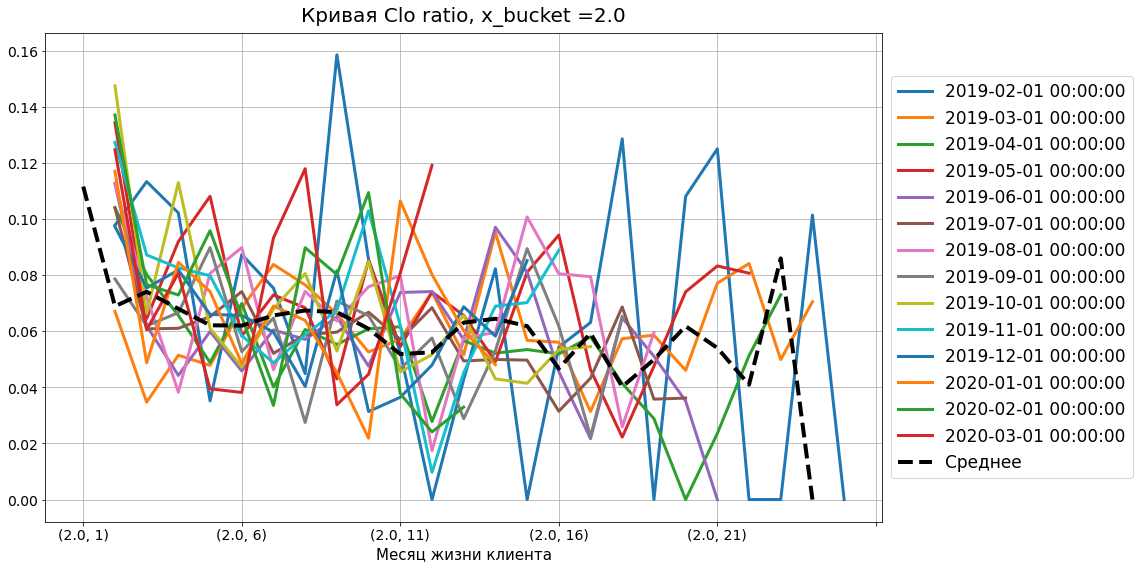

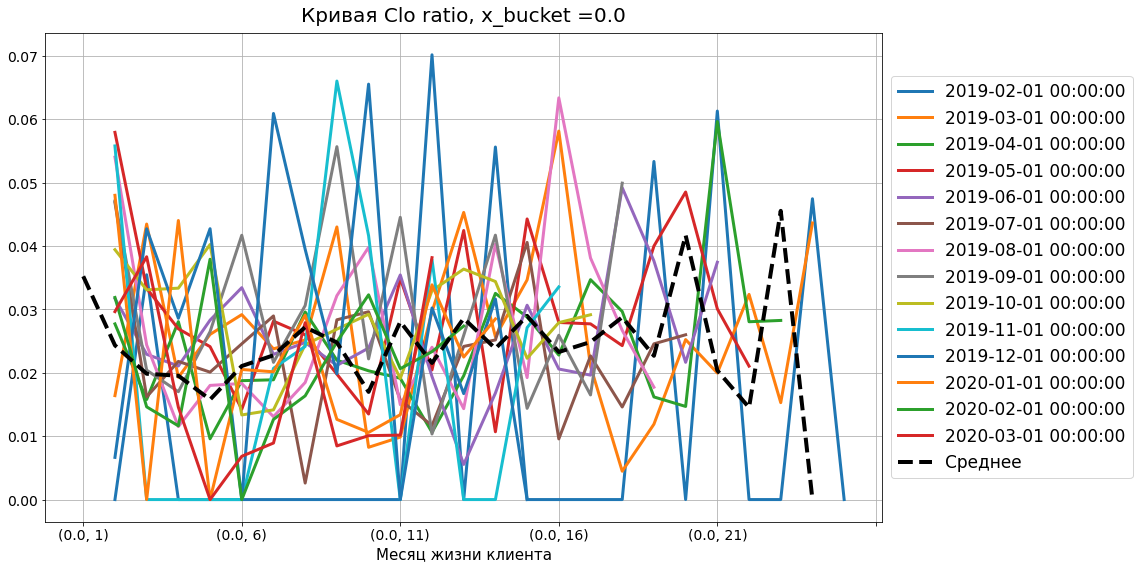

In [ ]:
clo_ratio_mean = res['fitted_data'].groupby(['x_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})

buckets = data_vintages['x_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_dlq_ratio_mean(x_bucket):
    vintages_graph = res['fitted_data'].query('x_bucket == ' + str(x_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature": np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (clo_ratio_mean.query('x_bucket == ' + str(x_bucket))['Среднее']
             .plot( figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Clo ratio, x_bucket =" + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_dlq_ratio_mean(i)

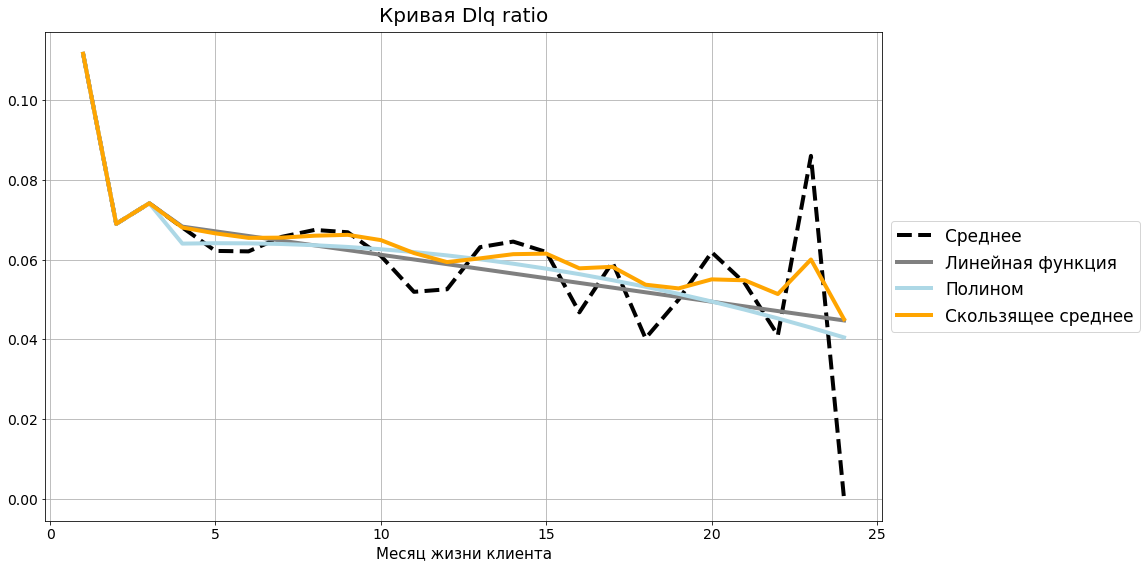

In [ ]:
df_linear = clo_ratio_mean.query('x_bucket == 2').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 4, 24)
df_polynom = polynom_approximation(df_linear, 4,24,2)
df_smooth = exponential_smoothing(df_polynom, 4,24, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

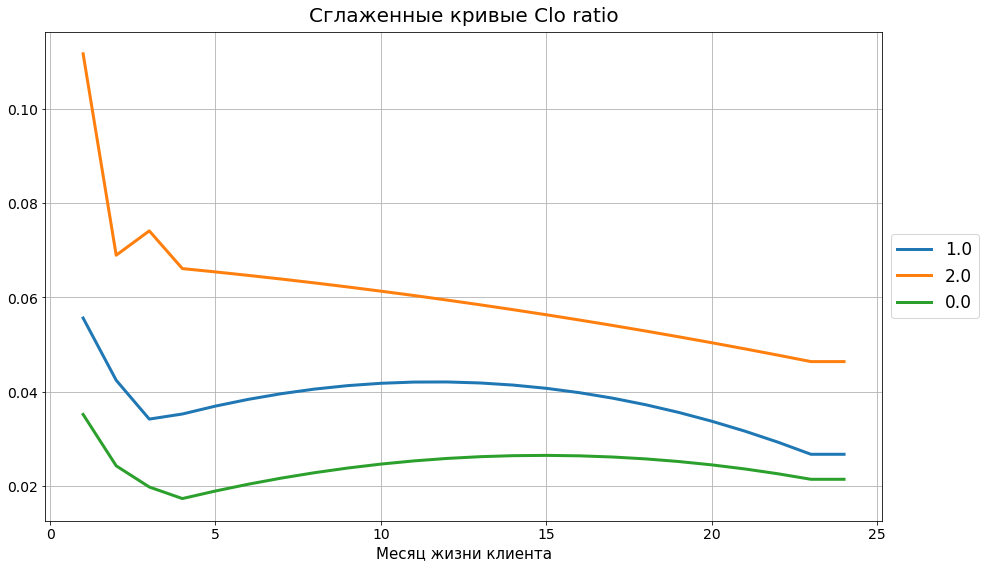

In [ ]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = data_vintages['x_bucket'].drop_duplicates()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = clo_ratio_mean.query('x_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 4,22,2)['Полином']
    
# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Clo ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)